In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

In [49]:
# reading json with important fit hyperparameters
with open(os.path.join('..', 'fit_config.json'), 'r') as json_file:
    config = json.load(json_file)

In [4]:
train_set = pd.read_csv(os.path.join('..', 'data', 'train.csv'))
test_set = pd.read_csv(os.path.join('..', 'data', 'test.csv'))

In [8]:
print('Train set shape:', train_set.shape)
print('Test set shape:', test_set.shape)

Train set shape: (77252, 488)
Test set shape: (33112, 487)


In [14]:
set(train_set.columns[train_set.columns != 'year_group']) == set(test_set.columns)

True

##### can make a concluision, that test set has the same feature columns as train set. "year_group" is response variable, "unique_num" is row identifier, while all the rest columns are feature vectors

In [3]:
train_set.head()

,unique_num,year_group,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,2,2,2,1,21058,3545,0,13,0.0,0,...,1,261tt1,2,6,2549anr12,1,41,91,31,5
1,3,4,1,1,21058,4222,283,3,0.0,0,...,0,328tt1,2,14,3030anr12,0,71,71,31,5
2,6,2,1,1,21058,4142,1808,31,0.0,0,...,0,282tt1,1,14,1633anr12,0,81,81,31,5
3,7,2,1,0,21058,4124,2185,14,0.0,0,...,0,246tt1,2,14,3603anr12,0,38,38,31,5
4,8,5,1,0,21058,4202,461,21058,0.0,0,...,0,246tt1,0,14,1627anr12,0,2,2,31,5


test_set.head()

##### column names are encoded, so it will not be possible to provide some feature engineering based on their names - only by their values

### Check missing values

In [42]:
for col_name in train_set.columns:
    if any(train_set[col_name].isnull()):
        print(col_name)

#### No missing values, so no need to fix them during modeling

### Work with categorical variables

In [60]:
cat_features = []
for col_name in train_set.columns[train_set.columns != 'year_group']:
    if train_set[col_name].nunique() < config['cat_feature_unique'] or type(train_set[col_name]) == str:
        cat_features.append(col_name) 

In [61]:
print("Number of categorical features detected:", len(cat_features))

Number of categorical features detected: 222


##### Almost half of the features in dataset are categorical due to our hyperparameters, so handling categorical variables will be essential for modeling 

### Now we can check correlation between continuous variables

In [72]:
df = train_set.drop(cat_features + ['unique_num', 'year_group'], axis=1)

In [73]:
df.head()

,5,6,8,15,17,21,22,23,24,25,...,470,471,472,473,474,475,476,477,479,482
0,3545,0,0.0,0,0,0,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0,0.013776,0.122807,0.0,0.0,116nbf,261tt1,2549anr12
1,4222,283,0.0,0,0,0,2.7451,0.0,2.7451,1.5686,...,0.2431,0.0,0.0,0.012981,0.071125,0.0,0.0,184nbf,328tt1,3030anr12
2,4142,1808,0.0,0,0,0,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0,0.000720,0.013245,0.0,0.0,194nbf,282tt1,1633anr12
3,4124,2185,0.0,0,0,0,0.0000,0.0,0.5098,0.5098,...,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,184nbf,246tt1,3603anr12
4,4202,461,0.0,0,0,0,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0,0.006609,0.005516,0.0,0.0,184nbf,246tt1,1627anr12


In [74]:
corr_matrix = df.corr().abs()

In [75]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [77]:
# Find index of feature columns with correlation greater than config threshhold
to_drop = [column for column in upper.columns if any(upper[column] > config['correlation_drop_coef'])]

In [79]:
print('Some features we need to drop due to high Pearson correlation coefficient:', to_drop)

Some features we need to drop due to high Pearson correlation coefficient: ['53', '73', '101', '102', '116', '117', '134', '163', '182', '210', '211', '225', '226', '272', '291', '319', '320', '334', '335', '381', '400', '428', '429', '443', '444', '464', '472']


### Let's now visualize some distributions and build some plots for retrieving useful insights

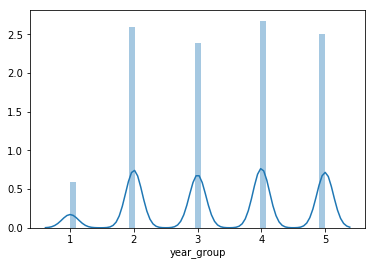

In [67]:
sns.distplot(train_set.year_group)

In [68]:
train_set.year_group.value_counts()

4    19221
2    18647
5    17946
3    17142
1     4296
Name: year_group, dtype: int64

##### As one can see, class '1' has much more less observations than the rest, so we should mention this while modeling: subsample/upsample classes' observations while building model, take it into account while constructing train/val sets etc